In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import matplotlib.dates as mdates

from sklearn.ensemble import RandomForestRegressor

In [2]:
md_path = '/Users/veronica/Library/CloudStorage/GoogleDrive-veronicahangsan@gmail.com/.shortcut-targets-by-id/1FsOPywSgK_wZmrVrSTBVi4q8G3Mg_yMJ/Team-Fermata-Energy/processed_data/md_one_hot_encoded_subset20.csv'
PATH = '/Users/veronica/Library/CloudStorage/GoogleDrive-veronicahangsan@gmail.com/.shortcut-targets-by-id/1FsOPywSgK_wZmrVrSTBVi4q8G3Mg_yMJ/Team-Fermata-Energy/processed_data/processed_weather_load_w_timestamp/'
json_file = '../data/subset20_20_data.json'

In [3]:
md = pd.read_csv(md_path)
with open(json_file, 'r') as file:
    json_data = json.load(file)

In [4]:
md.head

<bound method NDFrame.head of       bldg_id  in.state  in.vintage   in.sqft  \
0      105885        10           3  750000.0   
1      305819        40           2  150000.0   
2      305934        40           4  350000.0   
3      317044        40           3  350000.0   
4          32         1           6   37500.0   
...       ...       ...         ...       ...   
6396   331879        42           1   37500.0   
6397   331938        42           3   37500.0   
6398   332036        42           3    3000.0   
6399   332037        42           1   17500.0   
6400   332051        42           2   37500.0   

      in.building_america_climate_zone_Cold  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
6396                                      0   
6397 

In [5]:
md.columns

Index(['bldg_id', 'in.state', 'in.vintage', 'in.sqft',
       'in.building_america_climate_zone_Cold',
       'in.building_america_climate_zone_Hot-Dry',
       'in.building_america_climate_zone_Hot-Humid',
       'in.building_america_climate_zone_Marine',
       'in.building_america_climate_zone_Mixed-Dry',
       'in.building_america_climate_zone_Mixed-Humid',
       'in.building_america_climate_zone_Subarctic',
       'in.building_america_climate_zone_Very Cold', 'in.iso_rto_region_CAISO',
       'in.iso_rto_region_ERCOT', 'in.iso_rto_region_MISO',
       'in.iso_rto_region_NEISO', 'in.iso_rto_region_NYISO',
       'in.iso_rto_region_PJM', 'in.iso_rto_region_SPP',
       'in.iso_rto_region_none', 'in.heating_fuel_DistrictHeating',
       'in.heating_fuel_Electricity', 'in.heating_fuel_FuelOil',
       'in.heating_fuel_NaturalGas', 'in.heating_fuel_Propane',
       'in.interior_lighting_generation_gen1_t12_incandescent',
       'in.interior_lighting_generation_gen2_t8_halogen',
     

In [6]:
train_bldg_ids = json_data.get("train_bldg_ids", [])
test_bldg_ids = json_data.get("test_bldg_ids", [])

In [7]:
train_bldg_ids = [filename.split('.')[0] for filename in train_bldg_ids]
test_bldg_ids = [filename.split('.')[0] for filename in test_bldg_ids]

md['bldg_id'] = md['bldg_id'].astype(str).str.strip()

In [8]:
education_buildings = md[md['in.comstock_building_type_group_Education'] == 1]
education_bldg_ids = education_buildings['bldg_id'].unique()

In [9]:
print(f"Education Building IDs: {education_bldg_ids[:10]}")

Education Building IDs: ['1025' '3050' '3587' '5623' '5778' '6141' '7137' '10351' '12020' '13244']


In [10]:
valid_train_bldgs = set(train_bldg_ids).intersection(education_bldg_ids)
valid_test_bldgs = set(test_bldg_ids).intersection(education_bldg_ids)

print(f"Valid train buildings: {valid_train_bldgs}")
print(f"Valid test buildings: {valid_test_bldgs}")

Valid train buildings: {'300292', '202677', '129318', '235879', '41538', '147211', '105735', '297199', '317886', '146220', '116162', '177619', '99553', '104791', '76225', '241943', '112004', '315062', '313003', '184684', '160500', '197094', '268181', '87513', '236343', '68162', '232165', '224597', '308369', '174061', '258391', '91960', '5623', '166330', '317195', '282426', '220209', '325574', '185619', '18768', '222812', '309670', '191781', '131132', '200025', '304075', '290293', '100509', '300121', '242077', '76284', '296547', '216573', '15554', '32211', '193183', '202498', '256321', '324067', '142128', '10351', '100131', '122765', '129232', '40784', '114047', '157920', '233818', '302537', '85280', '222427', '132936', '173742', '51767', '140525', '33545', '286199', '49168', '172879', '28870', '130137', '130424', '175636', '5778', '97705', '198468', '38370', '257381', '142950', '260641', '141937', '325656', '306876', '143155', '324210', '115516', '183918', '239266', '213035', '82929', 

In [11]:
print(f"Number of valid training buildings: {len(valid_train_bldgs)}")
print(f"Number of valid testing buildings: {len(valid_test_bldgs)}")


Number of valid training buildings: 120
Number of valid testing buildings: 33


In [12]:
def load_data_for_building(filename, directory):
    try:
        file_path = f"{directory}/{filename}.csv"
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"Error loading file {filename}: {e}")
        return None


In [13]:
def prepare_data_for_building(df_load, md):
    df_load['bldg_id'] = df_load['bldg_id'].astype(str)
    md['bldg_id'] = md['bldg_id'].astype(str)

    for i in range(1, 97):
        df_load[f"shift_{i}"] = df_load["out.electricity.total.energy_consumption"].shift(i)

    if 'timestamp' in df_load.columns:
        df_load['timestamp'] = pd.to_datetime(df_load['timestamp'])
        
        datetime_columns = {
            'hour': df_load['timestamp'].dt.hour,
            'day_of_week': df_load['timestamp'].dt.dayofweek,
            'day_of_year': df_load['timestamp'].dt.dayofyear,
            'month': df_load['timestamp'].dt.month,
            'year': df_load['timestamp'].dt.year
        }
        
        df_load = pd.concat([df_load, pd.DataFrame(datetime_columns)], axis=1)
        df_load = df_load.drop(columns=['timestamp'])  # drop timestamp

    merged_df = df_load.merge(md, on='bldg_id', how='left')
    merged_df = merged_df.drop(['bldg_id'], axis=1)

    # drop missing values
    merged_df = merged_df.dropna()
    
    return merged_df

In [14]:
def smape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    denominator = np.abs(actual) + np.abs(predicted)
    diff = np.abs(actual - predicted) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

In [17]:
def train_random_forest_model(directory, valid_train_bldgs, valid_test_bldgs, target_column='out.electricity.total.energy_consumption'):
    smape_train_list = []
    smape_test_list = []

    model = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)

    for building_id in valid_train_bldgs:
        train_df = load_data_for_building(building_id, directory)
        if train_df is not None and target_column in train_df:
            train_df_prepared = prepare_data_for_building(train_df, md)
            
            if train_df_prepared is not None and len(train_df_prepared) > 0:
                
                # features (X) and target (y)
                X_train = train_df_prepared.drop(columns=[target_column])
                y_train = train_df_prepared[target_column]
                
                # Random Forest model
                model.fit(X_train, y_train)
                
                y_train_pred = model.predict(X_train)
                
                smape_train = smape(y_train, y_train_pred)
                smape_train_list.append(smape_train)
            
            else:
                print(f"Prepared data is empty for {building_id}")
        else:
            print(f"Skipping {building_id} due to missing data")

    # --- testing ---
    for building_id in valid_test_bldgs:   
        test_df = load_data_for_building(building_id, directory)
        if test_df is not None and target_column in test_df:
            test_df_prepared = prepare_data_for_building(test_df, md)
            
            if test_df_prepared is not None and len(test_df_prepared) > 0:
                
                # features (X) and target (y)
                X_test = test_df_prepared.drop(columns=[target_column])
                y_test = test_df_prepared[target_column]
                
                y_test_pred = model.predict(X_test)
                
                smape_test = smape(y_test, y_test_pred)
                smape_test_list.append(smape_test)
            
            else:
                print(f"Prepared data is empty for {building_id}")
        else:
            print(f"Skipping {building_id} due to missing data")

    # avg SMAPE for both training and testing sets
    avg_smape_train = np.mean(smape_train_list)
    avg_smape_test = np.mean(smape_test_list)

    print(f"Average SMAPE (training set): {avg_smape_train:.4f}")
    print(f"Average SMAPE (testing set): {avg_smape_test:.4f}")
    
    # overall (combined) average SMAPE
    overall_avg_smape = (avg_smape_train + avg_smape_test) / 2
    return overall_avg_smape, model


In [18]:
overall_smape, trained_model = train_random_forest_model(PATH, valid_train_bldgs, valid_test_bldgs)

# output the result
print(f"Final overall SMAPE: {overall_smape}")

Average SMAPE (training set): 1.1749
Average SMAPE (testing set): 53.7525
Final overall SMAPE: 27.46367750696517


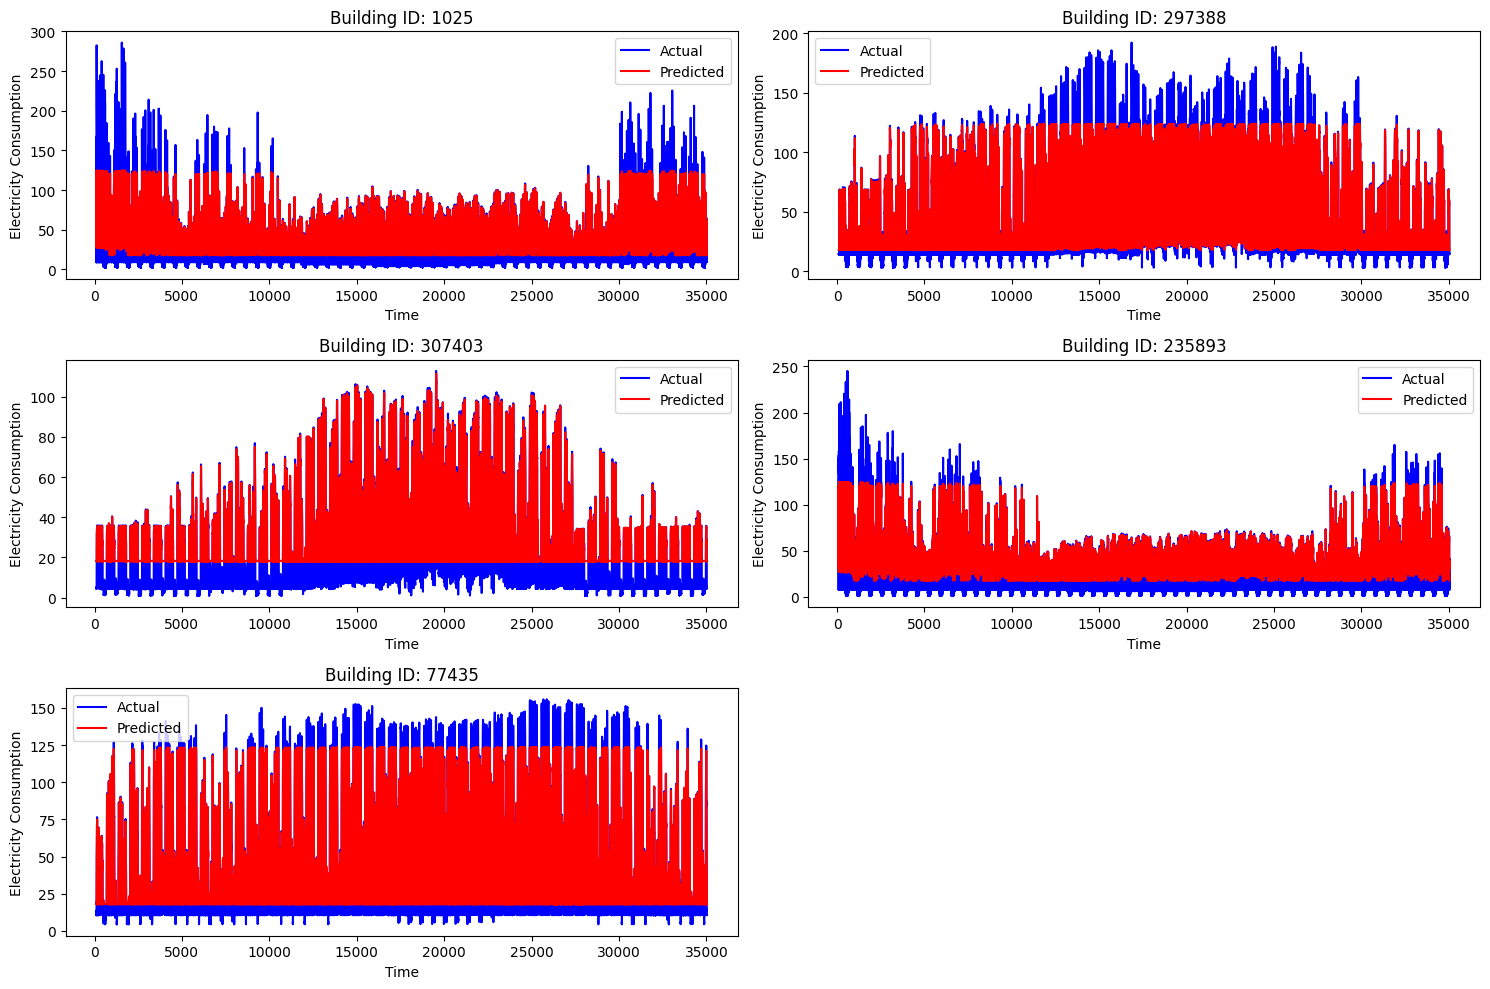

In [21]:
def plot_results_for_buildings(building_ids, directory, model):
    plt.figure(figsize=(15, 10))

    for i, building_id in enumerate(building_ids[:5]):
        df = load_data_for_building(building_id, directory)
        if df is not None:
            df_prepared = prepare_data_for_building(df, md)
            X = df_prepared.drop(columns=['out.electricity.total.energy_consumption'])
            y_actual = df_prepared['out.electricity.total.energy_consumption']
            
            y_pred = model.predict(X)

            plt.subplot(3, 2, i+1)
            plt.plot(df_prepared.index, y_actual, label='Actual', color='blue')
            plt.plot(df_prepared.index, y_pred, label='Predicted', color='red')
            plt.title(f'Building ID: {building_id}')
            plt.xlabel('Time')
            plt.ylabel('Electricity Consumption')
            plt.legend()

    plt.tight_layout()
    plt.show()

# plot first 5 buildings
plot_results_for_buildings(list(valid_test_bldgs), PATH, trained_model)

In [22]:
def check_timestamp(df):
    print(df['timestamp'].head())
    print(df['timestamp'].dtype)


In [23]:
valid_train_bldgs_list = list(valid_train_bldgs)
train_df = load_data_for_building(valid_train_bldgs_list[0], PATH)
check_timestamp(train_df)

0    2018-01-01 01:00:00
1    2018-01-01 01:15:00
2    2018-01-01 01:30:00
3    2018-01-01 01:45:00
4    2018-01-01 02:00:00
Name: timestamp, dtype: object
object
